In [10]:
from sliderule import icesat2
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as cx

In [11]:
icesat2.init("icesat2sliderule.org", verbose=False)

In [12]:
grand_mesa = icesat2.toregion('grandmesa.geojson')["poly"]

1312


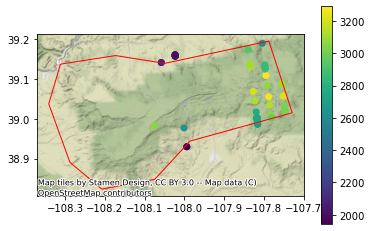

In [39]:
parms = {"poly": grand_mesa,
"srt": icesat2.SRT_LAND,
"cnf": [2],
"len": 100.0,
"res": 20.0,
"maxi": 1,
"t0":'2019-12-10T00:00:00Z',
"t1":'2020-04-12T00:00:00Z'}

rsps = icesat2.atl06p(parms)
rsps = rsps[rsps.h_sigma < 0.1]
rsps = rsps[rsps.n_fit_photons > 200]
# rsps['time'] = rsps.index
print(rsps.size)
f, ax = plt.subplots()
rsps.plot(column = 'h_mean', ax = ax, legend = True)
gpd.read_file('grandmesa.geojson').plot(facecolor = "none", edgecolor = 'red', ax = ax)
cx.add_basemap(ax, crs=rsps.crs.to_string())
plt.show()

In [40]:
rsps.to_file(f'test.geojson')

In [ ]:
rsps.describe()

,dh_fit_dy,n_fit_photons,segment_id,cycle,distance,delta_time,rms_misfit,gt,dh_fit_dx,pflags,w_surface_window_final,h_sigma,rgt,spot,h_mean
count,6985.0,6985.000000,6985.000000,6985.000000,6.985000e+03,6.985000e+03,6985.000000,6985.000000,6985.000000,6985.000000,6985.000000,6985.000000,6985.000000,6985.00000,6985.000000
mean,0.0,354.742591,493745.026915,5.791840,9.892157e+06,6.540892e+07,0.920763,42.647101,-0.008588,3.633787,4.217862,0.050400,782.311095,2.73529,2648.088556
std,0.0,102.519641,284193.373426,0.557842,5.689503e+06,3.214459e+06,0.451826,17.399503,0.124588,1.149931,1.745590,0.023932,363.084904,1.73995,463.983709
min,0.0,201.000000,215534.000000,5.000000,4.322410e+06,6.131044e+07,0.000000,10.000000,-0.605769,0.000000,3.000000,0.000000,211.000000,1.00000,1495.114615
25%,0.0,269.000000,216529.000000,5.000000,4.342335e+06,6.131044e+07,0.562977,20.000000,-0.076516,4.000000,3.000000,0.030680,295.000000,1.00000,2267.744630
50%,0.0,344.000000,217210.000000,6.000000,4.355978e+06,6.678518e+07,0.862729,40.000000,-0.002083,4.000000,3.309242,0.047928,737.000000,3.00000,2762.545212
75%,0.0,425.000000,784980.000000,6.000000,1.572260e+07,6.678518e+07,1.223579,60.000000,0.061955,4.000000,4.948314,0.068636,1156.000000,5.00000,3055.626446
max,0.0,734.000000,786151.000000,7.000000,1.574608e+07,7.165779e+07,2.329978,60.000000,0.468090,4.000000,15.459212,0.099987,1179.000000,6.00000,3347.455615


1029520
0.9691664736907342


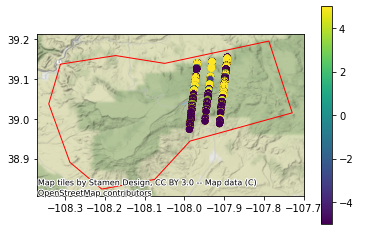

18870
5.330315490263323


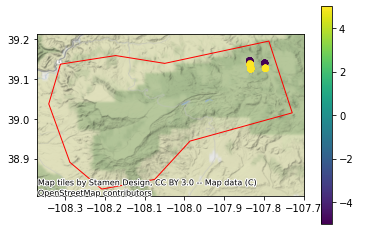

7276
11.910513451041927


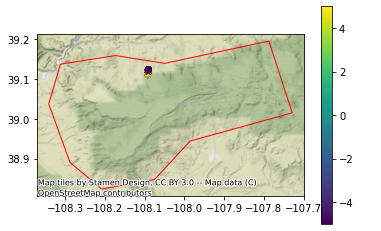

In [31]:
for d in np.unique(rsps.index.date):
    day = rsps[rsps.index.date == d]
    later_days = rsps[rsps.index.date > d]
    for other_date in np.unique(later_days.index.date):
        other_day = later_days[later_days.index.date == other_date]
        # Now reproject to a crs using meters
        day = day.to_crs(epsg = 3857)
        other_day = other_day.to_crs(epsg = 3857)
        # intersect = day.overlay(other_days, how='intersection')
        # Buffer and join
        day['geometry'] = day['geometry'].buffer(200)
        # intersection = gpd.sjoin(day, other_days, how='left')
        intersection = day.overlay(other_day, how='intersection', keep_geom_type=False)
        intersection = intersection.to_crs(rsps.crs)
        intersection['h_delta'] = intersection['h_mean_1'] - intersection['h_mean_2']
        if intersection.size > 0:
            print(intersection.size)
            print(res.h_delta.mean())
            f, ax = plt.subplots()
            intersection.plot(column = 'h_delta', legend = True, ax = ax, vmin = -5, vmax = 5)
            gpd.read_file('grandmesa.geojson').plot(facecolor = "none", edgecolor = 'red', ax = ax)
            cx.add_basemap(ax, crs=intersection.crs.to_string())
            plt.show()
            res = intersection.copy()